# Biobank_DBSCAN analysis

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import matplotlib.cm as cm
import matplotlib.animation as animation
import datetime
from dateutil.relativedelta import relativedelta
#import imblearn
import seaborn as sns
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import correlation
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# import data
df = pd.read_csv(r'./df_cluster_encoded_result.csv')
# drop last two columns
df = df.drop( columns=['kmedoid_cluster', 'kmeans_cluster',
                       '21003-2.0', '31-0.0']  )
print( df.shape )

# minmax scaler
min_max_scaler = MinMaxScaler()
df_mm = pd.DataFrame( min_max_scaler.fit_transform( df.drop(columns=['eid']) ) )
#0. Indexing
df_mm.set_index( df['eid'],inplace=True)
# 1. replacing column names
df_mm = df_mm.set_axis( [ '20458-0.0', '20459-0.0', '20460-0.0', '20479-0.0',
       '20485-0.0', '20495-0.0', '20497-0.0', '20498-0.0', '20505-0.0',
       '20506-0.0', '20507-0.0', '20508-0.0', '20509-0.0', '20510-0.0',
       '20511-0.0', '20512-0.0', '20513-0.0', '20514-0.0', '20515-0.0',
       '20516-0.0', '20517-0.0', '20518-0.0', '20519-0.0', '20520-0.0',
       '21025-0.0', '21033-0.0', '21034-0.0', '21040-0.0', '21041-0.0',
       '21042-0.0', '21043-0.0', '21044-0.0', '21048-0.0', '21049-0.0',
       '21051-0.0', '21052-0.0', '21053-0.0', '21054-0.0', '21055-0.0',
       '21056-0.0', '21057-0.0', '21058-0.0', '21059-0.0', '21060-0.0',
       '21061-0.0'], axis=1, inplace=False)
print(df_mm.shape)

(5772, 46)
(5772, 45)


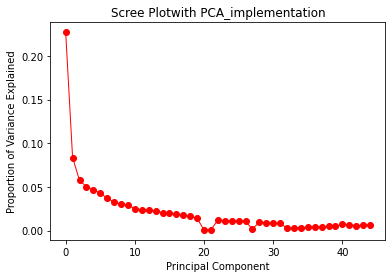

Text(0, 0.5, 'Pearson correlation distance')

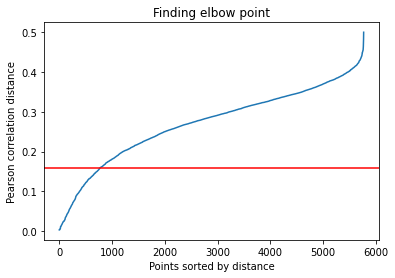

In [62]:
# Define PCA
class PCA_implementation:
  def __init__(self):
    self.X_centered = None
    self.values =     None
    self.vectors =    None

  def fit(self, X):
    self.X_centered = X - np.mean(X, axis=0)
    X_cov = np.cov(self.X_centered.T) 
    self.values,self.vectors = np.linalg.eig(X_cov)
    sort_index = np.argsort(self.values)[::-1]
    self.sort_values =  self.values[ sort_index ]   
    self.sort_vectors = self.vectors[ sort_index ]

  def transform(self, n_components):
    self.components = self.sort_vectors[0 : n_components]
    return np.dot(self.X_centered, self.components.T )

pca = PCA_implementation()
pca.fit(df_mm)
output = pca.transform(n_components = 45)
# save proportion of variance explained
variance = []
for i in range(0,45):
  variance.append( float((pca.values[i] / pca.values.sum() )) )

from sklearn.decomposition import PCA
pca_sklearn = PCA() 
pcs = pca_sklearn.fit_transform(df_mm)

# scree plot
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
PC_values = range(0,  len(pca.components) ) 
plt.plot(PC_values, variance, 'ro-', linewidth=1)
plt.title('Scree Plotwith PCA_implementation')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()


from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA

pca_sklearn = PCA() 
pcs = pca_sklearn.fit_transform(df_mm)
p = 20 # pick first 20 PCs
k = p + 1
input_data = pcs[:,0:p]
corr_distance = pairwise_distances(input_data , metric='correlation') # Peasron correlation distance

# plot to visualiza sorted distance -> to find optimal epsilon value
sort = np.sort(np.sort(corr_distance, axis=0)[15,:] )
plt.plot(sort)
plt.axhline(y=0.16, color='r', linestyle='-') # it seems like when eps=0.16 is the elbow point
plt.title('Finding elbow point')
plt.xlabel('Points sorted by distance')
plt.ylabel('Pearson correlation distance')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


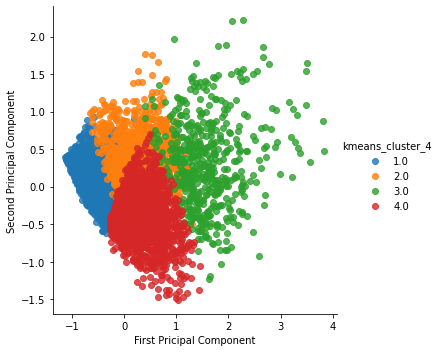

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


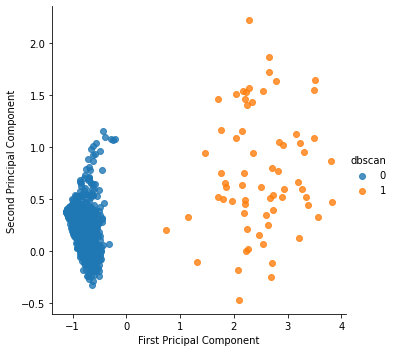

In [63]:
df = pd.read_csv('./brain_56cols_kmeans4.csv')
df.set_index('eid', inplace=True)

epsilon = 0.15  # from previous plot
min_point = k   # also from previous exercise

# build DBSCAN
clustering = DBSCAN(eps= epsilon,  
                    metric='correlation',  
                    min_samples= min_point).fit( input_data  )

df_mm['dbscan'] = clustering.labels_

# removing noise group (=-1)
df['dbscan'] = df_mm['dbscan']
df['pc1'] = pcs[:, 0] 
df['pc2'] = pcs[:, 1] 
df_fit = df[ (df['dbscan']>=0)  ]

# visualize
ax = sns.lmplot('pc1', 'pc2',   data=df, hue='kmeans_cluster_4', fit_reg=False)
ax.set(xlabel='First Pricipal Component', 
       ylabel='Second Principal Component')
plt.show()

ax = sns.lmplot('pc1', 'pc2', data=df_fit, hue='dbscan', fit_reg=False)
ax.set(xlabel='First Pricipal Component', 
       ylabel='Second Principal Component')
plt.show()

1. When epsilon value is : 0.01
-1    5741
 0      31
Name: dbscan, dtype: int64
2. median age :  dbscan
-1    64.0
 0    64.0
Name: age, dtype: float64
3. gender distribution are :  dbscan  gender
-1      0.0       3030
        1.0       2711
 0      1.0         26
        0.0          5
Name: gender, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


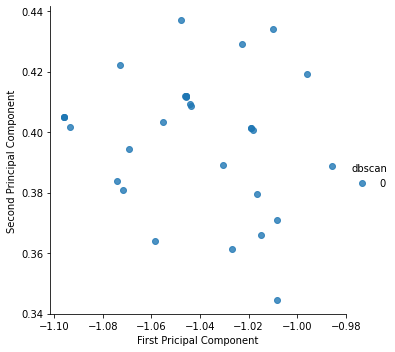

1. When epsilon value is : 0.04
-1    5569
 0     116
 1      30
 2      29
 3      28
Name: dbscan, dtype: int64
2. median age :  dbscan
-1    64.0
 0    64.0
 1    65.5
 2    65.0
 3    64.5
Name: age, dtype: float64
3. gender distribution are :  dbscan  gender
-1      0.0       2979
        1.0       2590
 0      1.0         78
        0.0         38
 1      1.0         22
        0.0          8
 2      1.0         26
        0.0          3
 3      1.0         21
        0.0          7
Name: gender, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


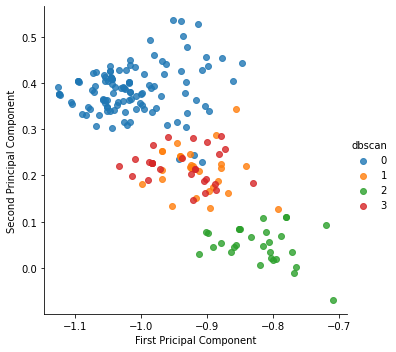

1. When epsilon value is : 0.06999999999999999
-1    5444
 0     165
 2      51
 1      41
 3      40
 4      31
Name: dbscan, dtype: int64
2. median age :  dbscan
-1    64.0
 0    63.0
 1    65.0
 2    66.0
 3    66.5
 4    61.0
Name: age, dtype: float64
3. gender distribution are :  dbscan  gender
-1      0.0       2930
        1.0       2514
 0      1.0        106
        0.0         59
 1      1.0         35
        0.0          6
 2      1.0         34
        0.0         17
 3      1.0         29
        0.0         11
 4      1.0         19
        0.0         12
Name: gender, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


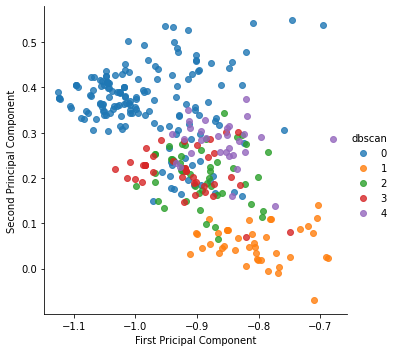

1. When epsilon value is : 0.09999999999999999
-1    5193
 0     559
 1      20
Name: dbscan, dtype: int64
2. median age :  dbscan
-1    63.0
 0    65.0
 1    61.5
Name: age, dtype: float64
3. gender distribution are :  dbscan  gender
-1      0.0       2840
        1.0       2353
 0      1.0        376
        0.0        183
 1      0.0         12
        1.0          8
Name: gender, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


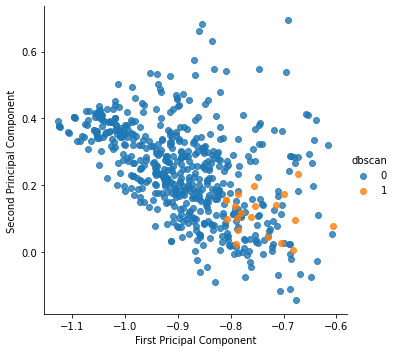

1. When epsilon value is : 0.13
-1    4905
 0     867
Name: dbscan, dtype: int64
2. median age :  dbscan
-1    63.0
 0    65.0
Name: age, dtype: float64
3. gender distribution are :  dbscan  gender
-1      0.0       2740
        1.0       2165
 0      1.0        572
        0.0        295
Name: gender, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


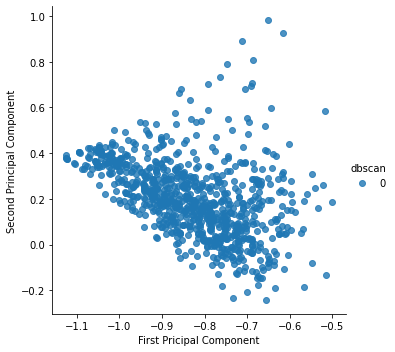

1. When epsilon value is : 0.16
-1    4393
 0    1267
 1     112
Name: dbscan, dtype: int64
2. median age :  dbscan
-1    63.0
 0    65.0
 1    60.0
Name: age, dtype: float64
3. gender distribution are :  dbscan  gender
-1      0.0       2489
        1.0       1904
 0      1.0        798
        0.0        469
 1      0.0         77
        1.0         35
Name: gender, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


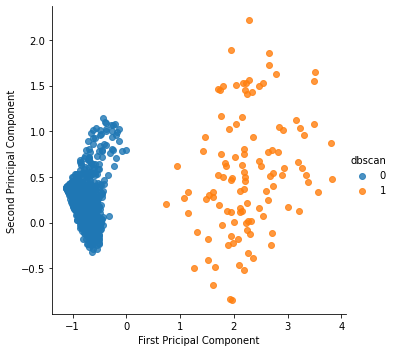

1. When epsilon value is : 0.19
-1    3860
 0    1671
 1     241
Name: dbscan, dtype: int64
2. median age :  dbscan
-1    63.0
 0    65.0
 1    61.0
Name: age, dtype: float64
3. gender distribution are :  dbscan  gender
-1      0.0       2246
        1.0       1614
 0      1.0       1037
        0.0        634
 1      0.0        155
        1.0         86
Name: gender, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


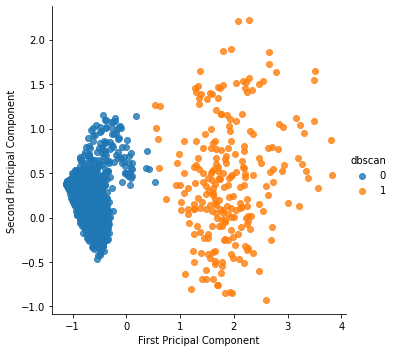

1. When epsilon value is : 0.22
-1    3159
 0    2073
 1     540
Name: dbscan, dtype: int64
2. median age :  dbscan
-1    63.0
 0    65.0
 1    60.0
Name: age, dtype: float64
3. gender distribution are :  dbscan  gender
-1      0.0       1852
        1.0       1307
 0      1.0       1246
        0.0        827
 1      0.0        356
        1.0        184
Name: gender, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


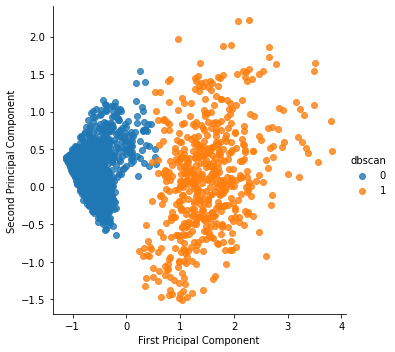

1. When epsilon value is : 0.25
 0    3407
-1    2347
 1      18
Name: dbscan, dtype: int64
2. median age :  dbscan
-1    63.0
 0    64.0
 1    60.0
Name: age, dtype: float64
3. gender distribution are :  dbscan  gender
-1      0.0       1408
        1.0        939
 0      1.0       1789
        0.0       1618
 1      0.0          9
        1.0          9
Name: gender, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


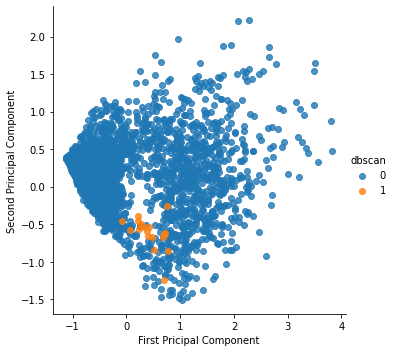

1. When epsilon value is : 0.28
 0    4316
-1    1456
Name: dbscan, dtype: int64
2. median age :  dbscan
-1    63.0
 0    64.0
Name: age, dtype: float64
3. gender distribution are :  dbscan  gender
-1      0.0        888
        1.0        568
 0      1.0       2169
        0.0       2147
Name: gender, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


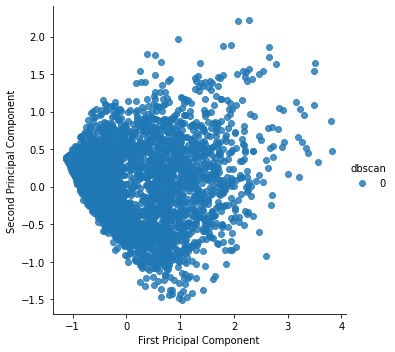

In [64]:
# Visualize with different epsilon value with loop
df['age'] = pd.read_csv(r'./df_cluster_encoded_result.csv')['21003-2.0'].tolist()
df['gender'] = pd.read_csv(r'./df_cluster_encoded_result.csv')['31-0.0'].tolist()

for i in np.arange(0.01, 0.3, 0.03):
    epsilon = i  # from previous plot
    min_point = k   # also from previous exercise
    
    clustering = DBSCAN(eps= epsilon, metric='correlation', min_samples= min_point).fit( input_data  )
    df_mm['dbscan'] = clustering.labels_
    df['dbscan'] = df_mm['dbscan']
    df['pc1'] = pcs[:, 0] 
    df['pc2'] = pcs[:, 1]
    df_fit = df[ (df['dbscan']>=0)  ]

    print("1. When epsilon value is :", i)
    print(df['dbscan'].value_counts() ) # group counts
    print("2. median age : ", df['age'].groupby(df['dbscan']).median() ) # median age
    print("3. gender distribution are : ", df['gender'].groupby(df['dbscan']).value_counts()  ) # count gender
    
    ax = sns.lmplot('pc1', 'pc2', data=df_fit, hue='dbscan', fit_reg=False)
    ax.set(xlabel='First Pricipal Component', 
           ylabel='Second Principal Component')
    plt.show()